In [10]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas
from tqdm import tqdm
import joblib



data_dir =Path('/common/home/vk405/Projects/EnergyLab/Solar-forcast/Data/')
image_dir = Path('/common/users/vk405/EnergyLab/Data')

In [11]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [12]:
#load data
#contains meteroligical readings data

files = os.listdir(data_dir)


def combine_dfs(data_dir,date_start='2012-01-01',date_end='2017-11-30',save=False,\
    files=['20120101.csv','20120601.csv','20150101.csv']):
    to_combine = []
    if not files:
        files = os.listdir(data_dir)
    for file in files:
        df1 = pd.read_csv(data_dir/file).dropna()
        df1.columns.values[[0,2]] = ['Date','GHI']
        to_combine.append(df1.iloc[:,[0,1,2]])
    df_combine = pd.concat(to_combine,axis=0)
    df_combine['Date'] = pd.to_datetime(df_combine['Date'])
    mask = (df_combine['Date'] >= datetime.strptime(str(date_start), '%Y-%m-%d')) & (df_combine['Date'] <= datetime.strptime(
                str(date_end), '%Y-%m-%d'))
    df_final = df_combine.loc[mask]
    if save:
        df_final.to_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'), index=False)
    return df_final


#df = combine_dfs(data_dir,save=True)



In [8]:
df_comb = combine_dfs(data_dir,save=False)

In [9]:
df_comb[df_comb['Date']== datetime.strptime(str('2012-04-25'), '%Y-%m-%d')]

,Date,MST,GHI
77547,2012-04-25,05:11,5.20950
77548,2012-04-25,05:12,6.25910
77549,2012-04-25,05:13,7.22490
77550,2012-04-25,05:14,8.24400
77551,2012-04-25,05:15,9.62060
...,...,...,...
78359,2012-04-25,18:43,0.23576
78360,2012-04-25,18:44,0.00000
78361,2012-04-25,18:45,0.00000
78362,2012-04-25,18:46,-0.27379


In [50]:
#df_comb.to_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'),index=False)

In [33]:
df_svd = pd.read_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'))
#df_svd['Date'] = pd.to_datetime(df_svd['Date'])
#df_svd[df_svd['Date']== datetime.strptime(str('2012-04-25'), '%Y-%m-%d')]

## Reproducing figure 4

In [52]:
temp = df_svd[pd.to_datetime(df_svd['Date']).dt.year == 2013]



In [53]:
temp = temp[(pd.to_datetime(temp['Date']).dt.day == 12) & (pd.to_datetime(temp['Date']).dt.month == 12)]

In [54]:
temp = temp[['MST','GHI']]
temp['MST'] = pd.to_datetime(temp['MST'])


<AxesSubplot:xlabel='MST'>

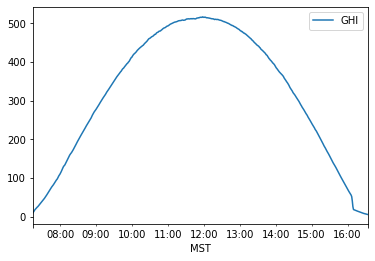

In [55]:
temp.plot(x='MST',y='GHI')

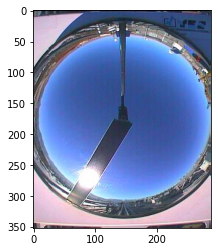

In [56]:
day_imgs = image_dir/'20131212'
smpl_img = day_imgs/'20131212140000.raw.jpg'
image = mpimg.imread(smpl_img)
plt.imshow(image)

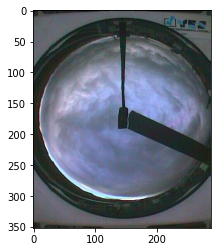

In [57]:
day_imgs = image_dir/'20141103'
smpl_img = day_imgs/'20141103072000.raw.jpg'
image = mpimg.imread(smpl_img)
plt.imshow(image)

In [58]:
temp = df_svd[pd.to_datetime(df_svd['Date']).dt.year == 2014]
temp = temp[(pd.to_datetime(temp['Date']).dt.day == 3) & (pd.to_datetime(temp['Date']).dt.month == 11)]

temp = temp[['MST','GHI']]
temp['MST'] = pd.to_datetime(temp['MST'])


<AxesSubplot:xlabel='MST'>

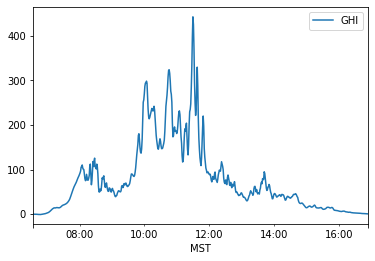

In [59]:
temp.plot(x='MST',y='GHI')

DONE.

In [60]:
df_svd['GHI'].describe()

count    1.577921e+06
mean     3.835746e+02
std      4.567182e+02
min     -9.999900e+04
25%      1.177000e+02
50%      3.157340e+02
75%      6.040190e+02
max      1.587360e+03
Name: GHI, dtype: float64

Note: It seems there are some negative values like `-99999`. Better to do some data cleaning before proceeding.

In [61]:
df_svd[df_svd['GHI']< 0.0].describe()

,GHI
count,1048.000000
mean,-1840.246560
std,13019.385185
min,-99999.000000
25%,-0.703759
50%,-0.338426
75%,-0.155381
max,-0.000174


In [62]:
len(df_svd[df_svd['GHI']< 0.0]['Date'].unique())

125

<AxesSubplot:ylabel='Frequency'>

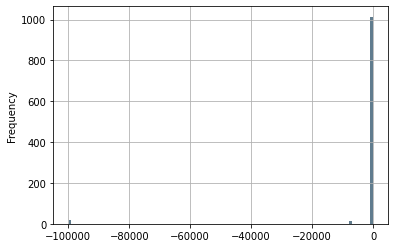

In [63]:
NEG_GHIs = df_svd[df_svd['GHI']< 0.0]['GHI']
NEG_GHIs.plot.hist(grid=True, bins=100, rwidth=0.9,
                   color='#607c8e')

            

In [64]:
#atm setting them to zero

df_svd[df_svd['GHI']< 0.0] = 0.0

In [65]:
df_svd[df_svd['GHI']< 0.0].sum()

Date    0.0
MST     0.0
GHI     0.0
dtype: float64

In [66]:
df_svd['GHI'].describe()

count    1.577921e+06
mean     3.847968e+02
std      3.048470e+02
min      0.000000e+00
25%      1.177000e+02
50%      3.157340e+02
75%      6.040190e+02
max      1.587360e+03
Name: GHI, dtype: float64

In [67]:
trn_df = df_svd.loc[pd.to_datetime(df_svd['Date']).dt.year <= 2014]
rst_df = df_svd.loc[pd.to_datetime(df_svd['Date']).dt.year > 2014]

In [68]:
trn_df.describe()

,GHI
count,798125.000000
mean,385.705715
std,303.783595
min,0.000000
25%,120.300000
50%,317.337000
75%,604.658000
max,1587.360000


In [69]:
rst_df.describe()

,GHI
count,779796.000000
mean,383.866558
std,305.928922
min,0.000091
25%,115.109500
50%,314.033000
75%,603.350250
max,1488.480000


As used by [authors](https://www.sciencedirect.com/science/article/pii/S0306261921016639#b47)

trn = 2012-01-01 to 2014-12-31

vld = 2015-01-01 to 2015-12-31

tst = 2016-01-01 to 2017-12-31

Preprocessing for image

In [70]:
# Image-data

date_start='2012-01-01'
date_end='2017-11-30'


In [71]:
%matplotlib inline

smpl_img = image_dir/'20150605'/'20150605072000.raw.jpg'
image = mpimg.imread(smpl_img)
image.shape

(352, 288, 3)

In [72]:
image

array([[[  0,   0,   7],
        [  0,   0,   7],
        [  0,   0,   7],
        ...,
        [  0,  15,   0],
        [ 64,  86,  65],
        [  0,  16,   0]],

       [[ 31,  30,  38],
        [ 30,  29,  37],
        [ 29,  28,  36],
        ...,
        [ 35,  54,  35],
        [ 80, 101,  82],
        [ 37,  60,  40]],

       [[ 29,  28,  34],
        [ 27,  26,  32],
        [ 27,  26,  32],
        ...,
        [ 25,  43,  27],
        [ 36,  57,  40],
        [ 30,  51,  34]],

       ...,

       [[ 29,  38,  35],
        [ 28,  37,  34],
        [ 26,  35,  32],
        ...,
        [ 47,  38,  33],
        [ 43,  32,  28],
        [ 52,  41,  37]],

       [[ 29,  39,  38],
        [ 28,  39,  35],
        [ 27,  39,  35],
        ...,
        [ 41,  32,  27],
        [ 46,  35,  31],
        [ 62,  51,  47]],

       [[ 26,  38,  36],
        [ 25,  37,  35],
        [ 23,  38,  33],
        ...,
        [ 39,  30,  25],
        [ 49,  38,  34],
        [ 76,  65,  61]]

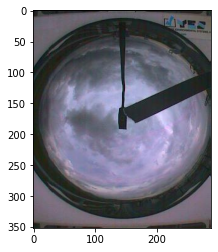

In [73]:
plt.imshow(image)

In [74]:
image.shape

(352, 288, 3)

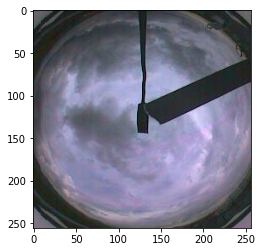

In [75]:
plt.imshow(image[48:352-48,16:288-16,:])

In [76]:
crpd_img = image[48:352-48,16:288-16,:]

In [77]:
mask = create_circular_mask(256,256)

In [78]:
out = crpd_img*np.expand_dims(mask,axis=2)
out.shape

(256, 256, 3)

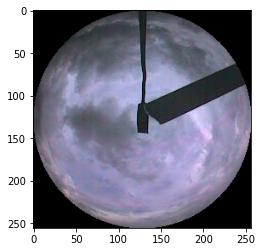

In [79]:
plt.imshow(out)

In [80]:
out.shape

(256, 256, 3)

We Daytime readings from 7:25 to 16:45

So below we will

- Generate targets btw 7:30,4:30 everyday.(next ten minute average)
- Based on lookback generate and store corresponding cropped images

In [31]:

def get_targets(df_svd):
    df_svd.loc[df_svd.index[df_svd['GHI']<=0.0],'GHI'] = 0.0
    start = datetime.fromisoformat("2012-01-01 07:30")
    end = datetime.fromisoformat("2012-01-01 16:40")
    sampl = pandas.date_range('2012-01-01','2012-01-02',freq='min')
    time_strs = set()

    for s_time in sampl:
        if s_time.time() >= start.time() and s_time.time() <= end.time():
            time_strs.add(s_time.time().strftime("%H:%M"))

    # for getting target times
    start = datetime.fromisoformat("2012-01-01 07:30")
    end = datetime.fromisoformat("2012-01-01 16:30")
    spaced_sampl = pandas.date_range('2012-01-01','2012-01-02',freq='10min')
    time_strs_spaced = set()
    for s_time in spaced_sampl:
        if s_time.time() >= start.time() and s_time.time() <= end.time():
            time_strs_spaced.add(s_time.time().strftime("%H:%M"))


    df_fltrd = df_svd[df_svd['MST'].isin(time_strs)].reset_index(drop=True)

    df_fltrd['roll_GHI'] = df_fltrd['GHI'].rolling(10).mean().shift(-10)

    final = df_fltrd[df_fltrd['MST'].isin(time_strs_spaced)].dropna().reset_index(drop=True)
    f = final[['Date','MST','GHI','roll_GHI']]
    f.columns.values[[3]] = ['Target']
    return f


In [82]:
import pandas
start = datetime.fromisoformat("2012-01-01 07:30")
end = datetime.fromisoformat("2012-01-01 16:40")
sampl = pandas.date_range('2012-01-01','2012-01-02',freq='min')
time_strs = set()

for s_time in sampl:
    if s_time.time() >= start.time() and s_time.time() <= end.time():
        time_strs.add(s_time.time().strftime("%H:%M"))


In [83]:
df_svd['GHI'].describe()

count    1.577921e+06
mean     3.847968e+02
std      3.048470e+02
min      0.000000e+00
25%      1.177000e+02
50%      3.157340e+02
75%      6.040190e+02
max      1.587360e+03
Name: GHI, dtype: float64

In [84]:
df_fltrd = df_svd[df_svd['MST'].isin(time_strs)].reset_index(drop=True)



In [85]:
df_fltrd['roll_GHI'] = df_fltrd['GHI'].rolling(10).mean().shift(-10)


<AxesSubplot:xlabel='MST'>

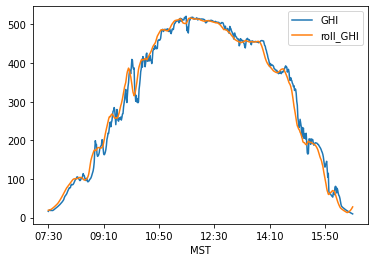

In [86]:
df_fltrd[df_fltrd['Date'] == '2012-01-01'].plot(x='MST',y=['GHI','roll_GHI'])

In [87]:
#sanity check

temp = df_fltrd[df_fltrd['Date'] == '2012-01-01']
assert temp.iloc[0]['roll_GHI'] == temp.iloc[1:11]['GHI'].mean(),'all bad'

In [88]:
start = datetime.fromisoformat("2012-01-01 07:30")
end = datetime.fromisoformat("2012-01-01 16:30")
spaced_sampl = pandas.date_range('2012-01-01','2012-01-02',freq='10min')
time_strs_spaced = set()
for s_time in spaced_sampl:
    if s_time.time() >= start.time() and s_time.time() <= end.time():
        time_strs_spaced.add(s_time.time().strftime("%H:%M"))

In [89]:
final = df_fltrd[df_fltrd['MST'].isin(time_strs_spaced)].dropna().reset_index(drop=True)

In [90]:
final.head()

,Date,MST,GHI,roll_GHI
0,2012-01-01,07:30,16.033,18.6734
1,2012-01-01,07:40,20.072,26.5878
2,2012-01-01,07:50,32.264,42.4806
3,2012-01-01,08:00,54.900,68.4412
4,2012-01-01,08:10,77.573,89.9590


In [91]:
f = final[['Date','MST','GHI','roll_GHI']]
f.columns.values[[3]] = ['Target']
f

,Date,MST,GHI,Target
0,2012-01-01,07:30,16.0330,18.67340
1,2012-01-01,07:40,20.0720,26.58780
2,2012-01-01,07:50,32.2640,42.48060
3,2012-01-01,08:00,54.9000,68.44120
4,2012-01-01,08:10,77.5730,89.95900
...,...,...,...,...
102875,2017-11-30,15:40,122.6220,106.00165
102876,2017-11-30,15:50,93.3656,80.20031
102877,2017-11-30,16:00,68.9675,47.26993
102878,2017-11-30,16:10,18.9934,15.55378


In [34]:
f = get_targets(df_svd)

,Date,MST,GHI
0,2012-01-01,07:25,10.99100
1,2012-01-01,07:26,12.32900
2,2012-01-01,07:27,13.69800
3,2012-01-01,07:28,15.00700
4,2012-01-01,07:29,15.51600
...,...,...,...
1577916,2017-11-30,16:30,7.39022
1577917,2017-11-30,16:31,6.93717
1577918,2017-11-30,16:32,6.44949
1577919,2017-11-30,16:33,5.92687


In [93]:
f['GHI'].describe()

count    102880.000000
mean        482.554530
std         301.267587
min           0.774718
25%         221.250500
50%         456.545500
75%         721.326250
max        1587.360000
Name: GHI, dtype: float64

## Does the GHI VALUES MAKES SENSE : does the cloudy imgs correspond to low values.

Checking the same cloudy day above after transformation.

In [94]:
temp = f[pd.to_datetime(f['Date']).dt.year == 2014]
temp = temp[(pd.to_datetime(temp['Date']).dt.day == 3) & (pd.to_datetime(temp['Date']).dt.month == 11)]


<AxesSubplot:xlabel='MST'>

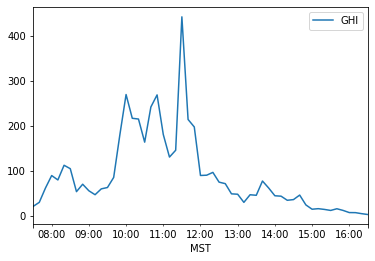

In [95]:
temp = temp[['MST','GHI','Target']]
temp['MST'] = pd.to_datetime(temp['MST'])
temp.plot(x='MST',y='GHI')


<AxesSubplot:xlabel='MST'>

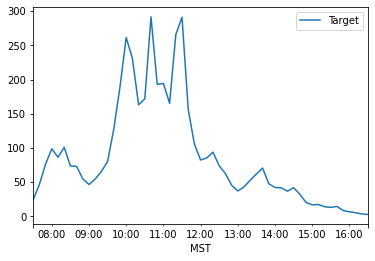

In [96]:
temp.plot(x='MST',y='Target')

Some more #sanity checking

In [97]:


f['GHI'].argmax(),f['GHI'].argmin()

(59140, 32998)

In [98]:
f.iloc[59140]

Date      2014-12-11
MST            10:10
GHI          1587.36
Target      611.4047
Name: 59140, dtype: object

In [99]:
f.iloc[32998]

Date      2013-08-22
MST            16:30
GHI         0.774718
Target      3.763561
Name: 32998, dtype: object

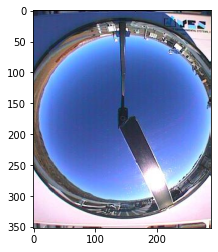

In [100]:
himg = mpimg.imread(image_dir/'20141211'/'20141211101000.raw.jpg')
plt.imshow(himg)

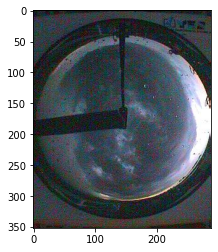

In [101]:
limg = mpimg.imread(image_dir/'20130822'/'20130822163000.raw.jpg')
plt.imshow(limg)

Makes sense. All seems to be good.

<AxesSubplot:ylabel='Frequency'>

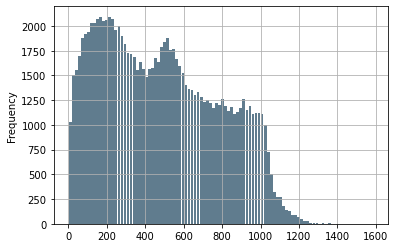

In [102]:
GHIS = f['GHI']
GHIS.plot.hist(grid=True, bins=100, rwidth=0.9,
                   color='#607c8e')

            

In [103]:
all_imgdirs = set(os.listdir(image_dir))

In [104]:
f

,Date,MST,GHI,Target
0,2012-01-01,07:30,16.0330,18.67340
1,2012-01-01,07:40,20.0720,26.58780
2,2012-01-01,07:50,32.2640,42.48060
3,2012-01-01,08:00,54.9000,68.44120
4,2012-01-01,08:10,77.5730,89.95900
...,...,...,...,...
102875,2017-11-30,15:40,122.6220,106.00165
102876,2017-11-30,15:50,93.3656,80.20031
102877,2017-11-30,16:00,68.9675,47.26993
102878,2017-11-30,16:10,18.9934,15.55378


In [35]:
all_imgdirs = set(os.listdir(image_dir))
lookback = 2
suffix = '.raw.jpg'

f_ims= []
f_targets = []
f_dates = []
f_times = []
missing = []
for ind in tqdm(range(len(f))):
    req_imgs = []
    d_str = f.iloc[ind]['Date']
    t_str = f.iloc[ind]['MST']
    tgt = f.iloc[ind]['Target']
    pres_time = datetime.fromisoformat(' '.join([d_str,t_str]))
    req_imgs.append(pres_time)
    for i in range(lookback-1):
        lst_t = req_imgs[-1]-timedelta(minutes=10)
        req_imgs.append(lst_t)
    presdir = req_imgs[0].strftime("%Y:%m:%d:%H:%M").replace(':','')[:-4]
    reqimg_files = [ele.strftime("%Y:%m:%d:%H:%M").replace(':','')+'00'+suffix for ele in req_imgs]

    if presdir in all_imgdirs:
            presdir_imgfiles = set(os.listdir(image_dir/presdir))
            all_fnd = all(ele in presdir_imgfiles for ele in reqimg_files)
            if all_fnd:
                f_targets.append(tgt)
                f_ims.append([str(image_dir/presdir/ele) for ele in reqimg_files])
                f_dates.append(d_str)
                f_times.append(t_str)
            else:
                missing.append([d_str,t_str])
    
d = pd.DataFrame({'Date':f_dates,'MST':f_times,'Imgs':f_ims,'Target':f_targets})

100%|██████████| 102882/102882 [02:02<00:00, 840.19it/s] 


In [38]:
d.tail()

,Date,MST,Imgs,Target
100882,2017-11-30,15:20,[/common/users/vk405/EnergyLab/Data/20171130/2...,161.97970
100883,2017-11-30,15:30,[/common/users/vk405/EnergyLab/Data/20171130/2...,133.98670
100884,2017-11-30,16:00,[/common/users/vk405/EnergyLab/Data/20171130/2...,47.26993
100885,2017-11-30,16:10,[/common/users/vk405/EnergyLab/Data/20171130/2...,15.55378
100886,2017-11-30,16:20,[/common/users/vk405/EnergyLab/Data/20171130/2...,9.61039


In [ ]:
#df_comb[df_comb['Date']== datetime.strptime(str('2012-04-25'), '%Y-%m-%d')]

In [36]:
# import joblib
# joblib.dump(missing,image_dir/'missing_imgs.joblib')

['/common/users/vk405/EnergyLab/Data/missing_imgs.joblib']

In [37]:
# d.to_csv(data_dir/'tgtimgs.csv',index=False)

In [ ]:

def get_tgtimgs(image_dir,f):
    all_imgdirs = set(os.listdir(image_dir))
    lookback = 2
    suffix = '.raw.jpg'

    f_ims= []
    f_targets = []
    f_dates = []
    f_times = []
    for ind in tqdm(range(len(f))):
        req_imgs = []
        d_str = f.iloc[ind][0]
        t_str = f.iloc[ind][1]
        tgt = f.iloc[ind][2]
        pres_time = datetime.fromisoformat(' '.join([d_str,t_str]))
        req_imgs.append(pres_time)
        for i in range(lookback-1):
            lst_t = req_imgs[-1]-timedelta(minutes=10)
            req_imgs.append(lst_t)
        presdir = req_imgs[0].strftime("%Y:%m:%d:%H:%M").replace(':','')[:-4]
        reqimg_files = [ele.strftime("%Y:%m:%d:%H:%M").replace(':','')+'00'+suffix for ele in req_imgs]
        
        #print(reqimg_files)
        #print(presdir)
        #print(presdir in all_imgdirs)
        #print(all_imgdirs)
        #print(len(os.listdir(image_dir/presdir)))
        #break
        if presdir in all_imgdirs:
            presdir_imgfiles = set(os.listdir(image_dir/presdir))
            all_fnd = all(ele in presdir_imgfiles for ele in reqimg_files)
            if all_fnd:
                f_targets.append(tgt)
                f_ims.append([str(image_dir/presdir/ele) for ele in reqimg_files])
                f_dates.append(d_str)
                f_times.append(t_str)
        
    d = pd.DataFrame({'Date':f_dates,'MST':f_times,'Imgs':f_ims,'Target':f_targets})
    return d
        

            
        




In [ ]:
df_tgtimgs = get_tgtimgs(image_dir,f)

100%|██████████| 308648/308648 [04:31<00:00, 1138.67it/s]


In [ ]:
df_tgtimgs.head(2)

,Date,MST,Imgs,Target
0,2012-01-01,07:40,[/common/users/vk405/EnergyLab/Data/20120101/2...,26.5878
1,2012-01-01,07:50,[/common/users/vk405/EnergyLab/Data/20120101/2...,42.4806


In [42]:
#removing negative values
df_svd = pd.read_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'))
#df_svd['Date'] = pd.to_datetime(df_svd['Date'])
df_svd.loc[df_svd.index[df_svd['GHI']<=0.0],'GHI'] = 0.0
#df_svd[df_svd['GHI']<= 0.0] = 0.0


In [47]:
def set_dt_time(df_svd):
    dts_list = []
    for ind in tqdm(range(len(df_svd))):
        d_str = df_svd.iloc[ind]['Date']
        t_str= df_svd.iloc[ind]['MST']
        try:
            dt = ' '.join([d_str,t_str])
        except:
            print(ind)
            exit()
        dts_list.append(dt)
    df_svd['DateTime'] = np.array(dts_list)
    return df_svd

        #pres_time = datetime.fromisoformat(' '.join([d_str,t_str]))



In [48]:
out = set_dt_time(df_svd)

100%|██████████| 1577921/1577921 [04:14<00:00, 6198.14it/s]


In [52]:
#out.to_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'),index=False)

In [53]:
df_svd = pd.read_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'))
df_svd.head()

,Date,MST,GHI,DateTime
0,2012-01-01,07:25,10.991,2012-01-01 07:25
1,2012-01-01,07:26,12.329,2012-01-01 07:26
2,2012-01-01,07:27,13.698,2012-01-01 07:27
3,2012-01-01,07:28,15.007,2012-01-01 07:28
4,2012-01-01,07:29,15.516,2012-01-01 07:29


In [54]:
df_svd.iloc[78361:78365]

,Date,MST,GHI,DateTime
78361,2012-04-25,18:45,0.000,2012-04-25 18:45
78362,2012-04-25,18:46,0.000,2012-04-25 18:46
78363,2012-04-25,18:47,0.000,2012-04-25 18:47
78364,2012-04-26,05:10,2.061,2012-04-26 05:10


In [56]:
df_tgt = pd.read_csv(os.path.join(data_dir, 'tgtimgs.csv'))
df_tgt.head(2)

,Date,MST,Imgs,Target
0,2012-01-01,07:40,['/common/users/vk405/EnergyLab/Data/20120101/...,26.5878
1,2012-01-01,07:50,['/common/users/vk405/EnergyLab/Data/20120101/...,42.4806


In [60]:
pres_time = datetime.fromisoformat(' '.join([df_tgt.iloc[0]['Date'],df_tgt.iloc[0]['MST']]))

In [67]:
import datetime
pst_time = pres_time -  datetime.timedelta(minutes=10)

In [68]:
df_svd['DateTime'] = pd.to_datetime(df_svd['DateTime'])
df_svd[(df_svd['DateTime'] >= pst_time) & (df_svd['DateTime'] <= pres_time)]

,Date,MST,GHI,DateTime
5,2012-01-01,07:30,16.033,2012-01-01 07:30:00
6,2012-01-01,07:31,17.699,2012-01-01 07:31:00
7,2012-01-01,07:32,19.783,2012-01-01 07:32:00
8,2012-01-01,07:33,19.342,2012-01-01 07:33:00
9,2012-01-01,07:34,18.155,2012-01-01 07:34:00
10,2012-01-01,07:35,18.422,2012-01-01 07:35:00
11,2012-01-01,07:36,18.262,2012-01-01 07:36:00
12,2012-01-01,07:37,17.904,2012-01-01 07:37:00
13,2012-01-01,07:38,18.133,2012-01-01 07:38:00
14,2012-01-01,07:39,18.962,2012-01-01 07:39:00


In [ ]:
df_svd

In [60]:
d_str = df_svd.iloc[0]['Date']
t_str= df_svd.iloc[0]['MST']
pres_time = datetime.fromisoformat(' '.join([d_str,t_str]))
pres_time

datetime.datetime(2012, 1, 1, 7, 25)

In [ ]:
d_str = f.iloc[ind]['Date']
    t_str = f.iloc[ind]['MST']
    tgt = f.iloc[ind]['Target']
    pres_time = datetime.fromisoformat(' '.join([d_str,t_str]))

In [ ]:
#df_svd.to_csv(os.path.join(data_dir, 'SRRL_measurement_timeseries.csv'),index=False)

## Storing preprocessed images 

In [6]:
df = pd.read_csv(f'{data_dir}/tgtimgs.csv')


In [14]:
proc_data_dir = Path('/common/users/vk405/EnergyLab/Data/ProcData')




def proc_image(image_loc,store_dir,save=False):
    store_fname = str(image_loc).split('/')[-1].replace('.raw.jpg','.joblib')
    image = mpimg.imread(image_loc)
    assert image.shape == (352, 288, 3),"shape mismatch"
    crpd_img = image[48:352-48,16:288-16,:]
    mask = create_circular_mask(256,256)
    out = crpd_img*np.expand_dims(mask,axis=2)
    if save:
        joblib.dump(out,store_dir/store_fname)
    

In [15]:
#store preprocessed images
seen = set()
for i in tqdm(range(len(df))):
    img_locs = eval(df.iloc[i]['Imgs'])
    for img_loc in img_locs:
        if img_loc not in seen:
            proc_image(img_loc,proc_data_dir,True)
            seen.add(img_loc)
        
            

100%|██████████| 100887/100887 [21:55<00:00, 76.68it/s] 


In [18]:
proc_imgs = os.listdir(proc_data_dir)


In [24]:
sampl_img = joblib.load(proc_data_dir/proc_imgs[0])

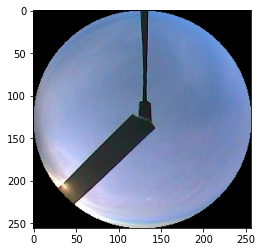

In [25]:
plt.imshow(sampl_img)